# Genetic Algorithm

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

## 1 求函数最值
遗传算法的特点有无须可导，可优化离散异构数据。

参考：
- [遗传算法python实现](https://blog.csdn.net/m0_38101326/article/details/90642193?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.nonecase&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.nonecase)
- [科学前沿：Genetic Algorithm - 遗传算法究竟怎么回事](https://ai.supergenius.cn/article/12/749)

### 1.1 问题定义
如下图所示，$f(x) = x \cdot sin(10\pi \cdot x)$在区间`[-1, 2]`上有很多极大值和极小值，如果要求其最大值或最小值，很多单点优化的方法（梯度下降等）就不适合，这种情况下就可以用遗传算法（Genetic Algorithm）。

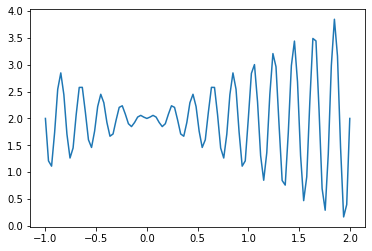

In [2]:
def fun(x):
    return x * np.sin(10*np.pi*x) + 2

Xs = np.linspace(-1, 2, 100)
plt.plot(Xs, fun(Xs))

### 1.2 初始化原始种群
遗传算法的一个特点是同时优化一批解（种群），例如下面在`[-1, 2]`范围内随机生成$10$个点：

In [3]:
np.random.seed(0)

# 初始化原始种群
def ori_popular(num, _min=-1, _max=2):
    return np.random.uniform(_min, _max, num) # 范围[-1, 2)

x= 0.65, fit=2.64
x= 1.15, fit=0.87
x= 0.81, fit=2.21
x= 0.63, fit=2.56
x= 0.27, fit=2.21
x= 0.94, fit=1.13
x= 0.31, fit=1.88
x= 1.68, fit=3.17
x= 1.89, fit=2.53
x= 0.15, fit=1.85


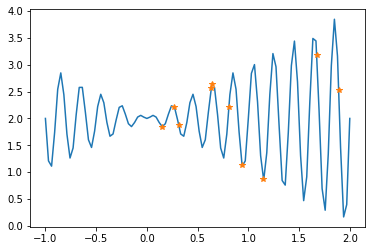

In [4]:
#__TEST__
population = ori_popular(10)

for pop, fit in zip(population, fun(population)):
    print("x=%5.2f, fit=%.2f"%(pop, fit))

plt.plot(Xs, fun(Xs))
plt.plot(population, fun(population), '*')
plt.show()

上图显示我们随机选的$10$个点离最大值（3.8左右）差距还挺远，下面用GA算法看能否求到最优解。

### 1.3 编码
编码，也就是由表现型到基因型，性征到染色体。

二进制编码的缺点：对于一些连续函数的优化问题，由于其随机性使得其局部搜索能力较差，如对于一些高精度的问题，当解迫近于最优解后，由于其变异后表现型变化很大，不连续，所以会远离最优解，达不到稳定。而格雷码能有效地防止这类现象。

TODO:
- [ ] 用`2**18`扩展似乎会损失精度，准备用`10000`代替

下面分别将`1, 10, 0`转成二进制编码，注意浮点数`0.1`无法转换：

In [5]:
print("1:", bin(1))
print("10:", bin(10))
print("0:", bin(0))

try:
    print("0.1:", bin(0.1))
except Exception as E:
    print("Exception: {}".format(type(E).__name__), E)

1: 0b1
10: 0b1010
0: 0b0
Exception: TypeError 'float' object cannot be interpreted as an integer


为了能编码浮点数，需要扩大倍数转成整数：

In [6]:
X = [1, 0.1, 0.002]

print("2**18 =", 2**18, '\n')
for x in X:
    tx = int(x * 2**18)
    print("%.4f => %6d => %s"%(x, tx, bin(tx)))

2**18 = 262144 

1.0000 => 262144 => 0b1000000000000000000
0.1000 =>  26214 => 0b110011001100110
0.0020 =>    524 => 0b1000001100


In [7]:
for x in X:
    tx = int(x * 2**18)
    ex = bin(tx)
    dx = int(ex, 2) / 2**18
    print("%25s => %6d => %.4f"%(ex, tx, dx))

    0b1000000000000000000 => 262144 => 1.0000
        0b110011001100110 =>  26214 => 0.1000
             0b1000001100 =>    524 => 0.0020


需要注意的是，上面用`%.4f`进行了四舍五入，实际上用`2**18=262144`来放大编码会有精度的损失，例如：

In [8]:
x = 0.1
tx = int(x * 2**18)
ex = bin(tx)
int('0b110011001100110', 2) / (2**18)

0.09999847412109375

In [9]:
def encode(popular, _min=-1, _max=2, scale=2**18, bin_len=18):  # popular应该是float类型的列表
    """
        bin_len: 染色体序列长度
    """
    norm_data = (popular-_min) / (_max-_min) * scale
    bin_data = np.array([np.binary_repr(x, width=bin_len) for x in norm_data.astype(int)]) # 转成二进制编码
    return bin_data

In [10]:
chroms = encode(population)
for pop, chrom, fit in zip(population, chroms, fun(population)):
    print("x=%.2f, chrom=%s, fit=%.2f"%(pop, chrom, fit))

x=0.65, chrom=100011000111111100, fit=2.64
x=1.15, chrom=101101110001011010, fit=0.87
x=0.81, chrom=100110100100111010, fit=2.21
x=0.63, chrom=100010110111110101, fit=2.56
x=0.27, chrom=011011000111010010, fit=2.21
x=0.94, chrom=101001010101100101, fit=1.13
x=0.31, chrom=011100000000010110, fit=1.88
x=1.68, chrom=111001000100101100, fit=3.17
x=1.89, chrom=111101101011001010, fit=2.53
x=0.15, chrom=011000100010100100, fit=1.85


### 1.4 解码和适应度函数
通过基因（染色体）得到个体的适应度值，也就是评判当前种群每个个体（解）表现好坏，要对编码解码后才能代入函数。

注意，因为函数$f(x) = x \cdot sin(10\pi \cdot x)$的结果就是大小，所以直接用来当适应度函数。

In [11]:
def decode(popular_gene, _min=-1, _max=2, scale=2**18):
    return np.array([(np.int(x, base=2)/scale*3)+_min for x in popular_gene])

fitness = fun(decode(chroms))

In [12]:
for pop, chrom, dechrom, fit in zip(population, chroms, decode(chroms), fitness):
    print("x=%5.2f, chrom=%s, dechrom=%.2f, fit=%.2f"%(pop, chrom, dechrom, fit))

x= 0.65, chrom=100011000111111100, dechrom=0.65, fit=2.64
x= 1.15, chrom=101101110001011010, dechrom=1.15, fit=0.87
x= 0.81, chrom=100110100100111010, dechrom=0.81, fit=2.21
x= 0.63, chrom=100010110111110101, dechrom=0.63, fit=2.56
x= 0.27, chrom=011011000111010010, dechrom=0.27, fit=2.21
x= 0.94, chrom=101001010101100101, dechrom=0.94, fit=1.13
x= 0.31, chrom=011100000000010110, dechrom=0.31, fit=1.88
x= 1.68, chrom=111001000100101100, dechrom=1.68, fit=3.17
x= 1.89, chrom=111101101011001010, dechrom=1.89, fit=2.53
x= 0.15, chrom=011000100010100100, dechrom=0.15, fit=1.85


这里将最小的适应度调整到0.000001，主要为了防止负数。

In [13]:
fitness = fitness - fitness.min() + 0.000001 # 保证所有的都为正

### 1.5 选择与交叉
选择就是淘汰不好的染色体（解），选择方式有很多，这里用轮牌赌。

交叉就是让染色体相互交换基因，方式有很多，这里在染色体中间进行交叉，交叉概率默认为0.66。

In [14]:
def SelectandCrossover(chroms, fitness, prob=0.6):
    probs = fitness/np.sum(fitness)  # 各个个体被选择的概率
    probs_cum = np.cumsum(probs)  # 概率累加分布

    each_rand = np.random.uniform(size=len(fitness))
    #print(np.round(fitness, 2), np.round(probs, 2), np.round(probs_cum, 2), sep='\n')
    #print([np.where(probs_cum > rand)[0][0] for rand in each_rand])
    
    # 根据随机概率选择出新的基因编码
    newX = np.array([chroms[np.where(probs_cum > rand)[0][0]] for rand in each_rand])
    
    # 繁殖，随机配对（概率为0.6)
    pairs = np.random.permutation(int(len(newX)*prob//2*2)).reshape(-1, 2)
    center = len(newX[0])//2
    for i, j in pairs:
        # 在中间位置交叉
        x, y = newX[i], newX[j]
        newX[i] = x[:center] + y[center:]
        newX[j] = y[:center] + x[center:]
        #print(x, y, newX[i], '', sep='\n')

    return newX    

chroms = SelectandCrossover(chroms, fitness)

chrom=111101101000010110, dec= 1.89, fit=2.64
chrom=011100000011001010, dec= 0.31, fit=1.86
chrom=011100000010100100, dec= 0.31, fit=1.86
chrom=011000100000010110, dec= 0.15, fit=1.85
chrom=100011000111111100, dec= 0.65, fit=2.64
chrom=100011000111111100, dec= 0.65, fit=2.64
chrom=100011000111111100, dec= 0.65, fit=2.64
chrom=111101101011001010, dec= 1.89, fit=2.53
chrom=111001000100101100, dec= 1.68, fit=3.17
chrom=111101101011001010, dec= 1.89, fit=2.53


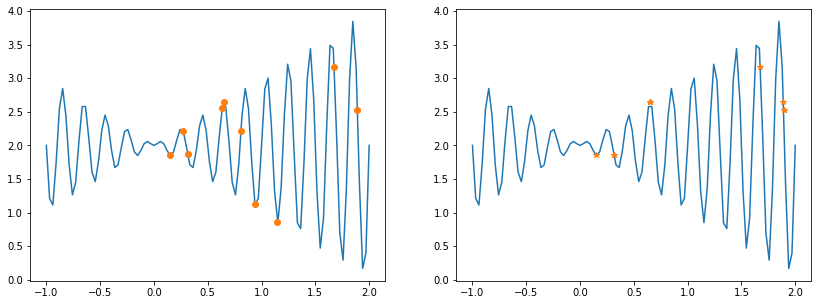

In [15]:
dechroms = decode(chroms)
fitness = fun(dechroms)

for gene, dec, fit in zip(chroms, dechroms, fitness):
    print("chrom=%s, dec=%5.2f, fit=%.2f"%(gene, dec, fit))

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 5))
axs1.plot(Xs, fun(Xs))
axs1.plot(population, fun(population), 'o')
axs2.plot(Xs, fun(Xs))
axs2.plot(dechroms, fitness, '*')
plt.show()

### 1.6 变异
如果现在我们从生物学的角度来看这个问题，那么请问：由上述过程产生的后代是否有和其父母一样的性状呢？答案是否。在后代的生长过程中，它们体内的基因会发生一些变化，使得它们与父母不同。这个过程我们称为「变异」，它可以被定义为染色体上发生的随机变化，正是因为变异，种群中才会存在多样性。

In [16]:
def Mutate(chroms:np.array):
    prob = 0.1
    clen = len(chroms[0])
    m = {'0':'1', '1':'0'}
    newchroms = []
    each_prob = np.random.uniform(size=len(chroms))
    for i, chrom in enumerate(chroms):
        if each_prob[i] < prob:
            pos = np.random.randint(clen)    
            chrom = chrom[:pos] + m[chrom[pos]] + chrom[pos+1:]
        newchroms.append(chrom)
    return np.array(newchroms)

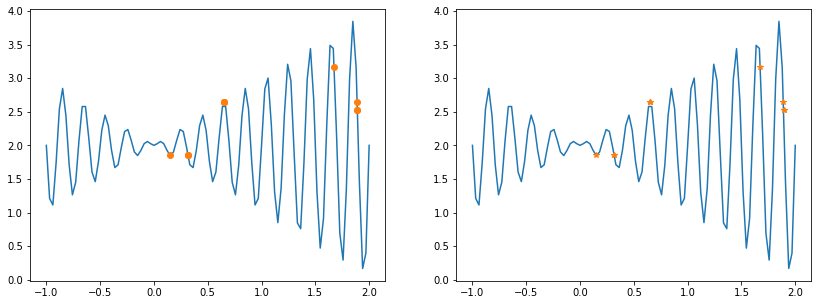

In [17]:
newchroms = Mutate(chroms)

def PltTwoChroms(chroms1, chroms2, fitfun):
    Xs = np.linspace(-1, 2, 100)
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 5))
    dechroms = decode(chroms1)
    fitness = fitfun(dechroms)
    axs1.plot(Xs, fitfun(Xs))
    axs1.plot(dechroms, fitness, 'o')
    
    dechroms = decode(chroms2)
    fitness = fitfun(dechroms)
    axs2.plot(Xs, fitfun(Xs))
    axs2.plot(dechroms, fitness, '*')
    plt.show()

PltTwoChroms(chroms, newchroms, fun)

### 1.7 完整运行
上面我们分解了每一步的运算，下面我们用GA算法完整地迭代求出最优解，这里种群个数为100，迭代次数为1000：

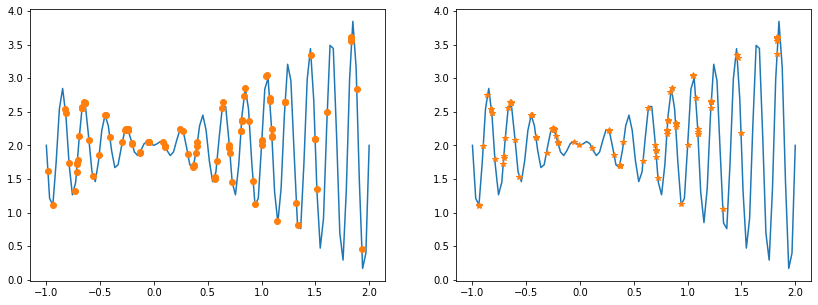

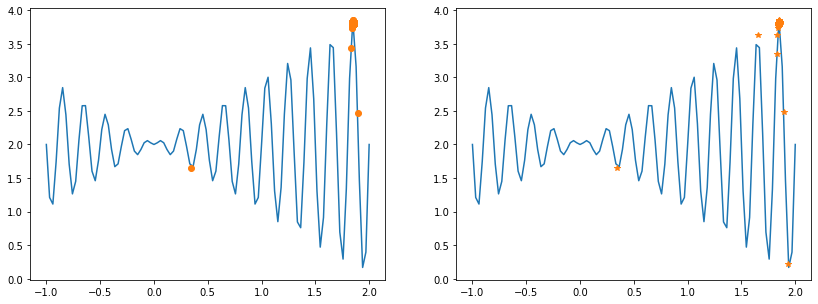

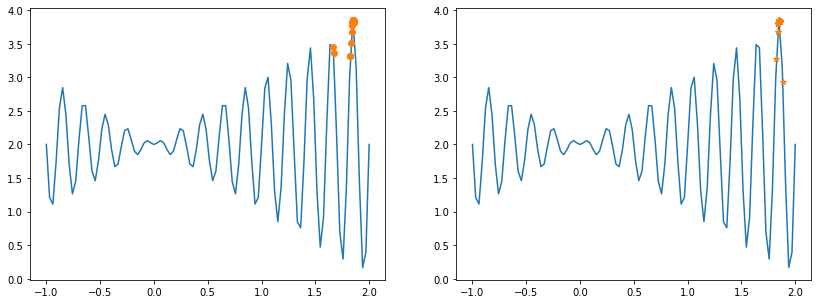

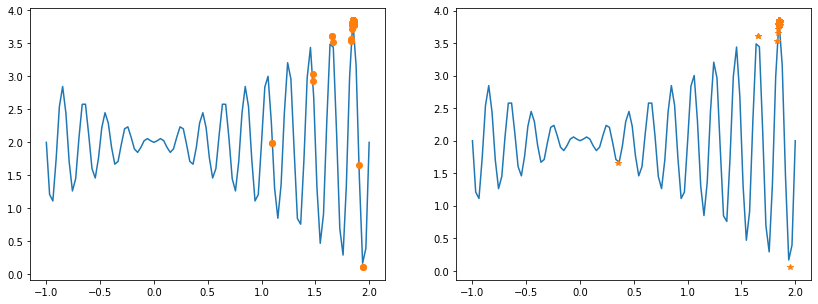

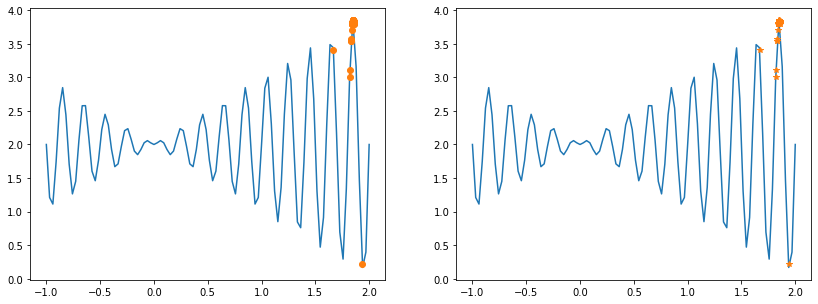

In [18]:
np.random.seed(0)
population = ori_popular(100)
chroms = encode(population)

for i in range(1000):
    fitness = fun(decode(chroms))
    fitness = fitness - fitness.min() + 0.000001 # 保证所有的都为正
    newchroms = Mutate(SelectandCrossover(chroms, fitness))
    if i % 300 == 1:
        PltTwoChroms(chroms, newchroms, fun)
    chroms = newchroms
    
PltTwoChroms(chroms, newchroms, fun)

### 1.8 深入思考
其实GA每一步都有各种各样的算法，包括超参数（种群个数、交叉概率、变异概率），没有一套组合适合所有的情况，需要根据实际情况来调整。例如我们在进行“选择与交叉”时，可以考虑保留5%最优秀的（因为有一定概率被淘汰），甚至这5%都不去交叉。

## 2 背包问题
背包问题是一个典型的优化组合问题：有一个容量固定的背包，已知$n$个物品的体积及其价值，我们该选择哪些物品装入背包使得在其容量约束限制之内所装物品的价值最大？比如：背包容量限制为$C=9$，有$4$个物品的体积为$\{2,3,4,5\}$，其价值则分别是$\{3,4,5,7\}$。

背包问题在计算理论中属于NP-完全问题，传统的算法是动态规划法，可求出最优总价值为$12$，其时间复杂度对于输入是指数级的。而如果用贪心算法，计算物品性价比依次为$\{1.5,1.33,1.25,1.4\}$，依次选择物品$1$和$4$，总价值只能达到$10$，这并非最优解。

现在我们试用遗传算法求解这个问题。

### 2.1 编码
将待求解的各量表示成长度为n的二进制串。例如：$1010$代表一个解，它表示将第$1$、$3$号物体放入背包中，其它的物体则不放入。

### 2.2 生成初始种群
本例中，群体规模的大小取为$4$，即群体由$4$个个体组成，每个个体可通过随机的方法产生。例如：

In [19]:
np.random.seed(0)
X = np.random.randint(0, 2, size=(4,4))
X

array([[0, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [0, 1, 0, 0]])

### 2.3 种群适应度计算
对每个个体，计算所有物体的体积`totalSize`，所有物体的价值`totalValue`，以及个体适应度`fit`。若所有物体的总体积小于背包容量`C`，`fit`就是`totalValue`；否则应进行惩罚，`fit`应减去`alpha∗(totalSize−C)`，这里我们取`alpha=2`，得到如下结果：

In [20]:
each_size = np.array([2, 3, 4, 5])
each_value = np.array([3, 4, 5, 7])
C = 9
alpha = 2

each_fit = np.zeros_like(each_size)
for i, x in enumerate(X):
    total_size = (x*each_size).sum()
    total_value = (x*each_value).sum()
    fit = total_value if (total_size <= C) else total_value - alpha*(total_size - C)
    each_fit[i] = fit
    print("x=%s, total_size=%d, total_value=%d, fit=%d"%(x, total_size, total_value, fit))

x=[0 1 1 0], total_size=7, total_value=9, fit=9
x=[1 1 1 1], total_size=14, total_value=19, fit=9
x=[1 1 1 0], total_size=9, total_value=12, fit=12
x=[0 1 0 0], total_size=3, total_value=4, fit=4


### 2.4 选择
根据染色体适应度，我们可以采用轮盘赌进行染色体的选择，即与适应度成正比的概率来确定每个个体复制到下一代群体中的数量。具体操作过程如下：

1. 先计算出群体中所有个体的适应度的总和。
2. 然后用每个个体适应度除以总和，结果就是个体被遗传到下一代群体中的概率。
3. 每个概率值组成一个区间，全部概率值之和为$1$。
4. 最后再产生一个`[0, 1]`之间的随机数，依据该随机数出现在上述哪一个区间内来确定各个个体被选中的次数。

In [21]:
fit_sum = each_fit.sum()
probs = each_fit / fit_sum
probs_cum = probs.cumsum()

for i, x in enumerate(X):
    print('probility of %s is %.2f%%'%(x, probs[i]*100))
print('cumulative sum of the probilities:', np.round(probs_cum, 4)*100)

probility of [0 1 1 0] is 26.47%
probility of [1 1 1 1] is 26.47%
probility of [1 1 1 0] is 35.29%
probility of [0 1 0 0] is 11.76%
cumulative sum of the probilities: [ 26.47  52.94  88.24 100.  ]


In [22]:
new_num = 4
each_rand = np.random.uniform(size=4)

np.round(each_rand, 2)

array([0.96, 0.38, 0.79, 0.53])

我们随机产生了$4$个`[0-1)`之间的数`each_rand`，用于在`probs_cum`中符合的区间上选中对应的基因编码，分别选中了第`88.24~100`、`26.47~52.94`、`52.94~88.24`和`26.47~52.94`上的区间，所以新的基因编码为：

In [23]:
newX = np.array([ X[np.where(probs_cum > rand)[0][0]] for rand in each_rand])

newX

array([[0, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

没想到概率最大的`[1 1 1 0]`反而被淘汰了。

### 2.5 交叉
采用单点交叉的方法，先对群体进行随机配对，其次随机设置交叉点位置，最后再相互交换配对染色体之间的部分基因。

### 2.6 突变

我们采用基本位变异的方法来进行变异运算，首先确定出各个个体的基因变异位置，然后依照某一概率将变异点的原有基因值取反。若突变之后最大的适应值个体已经符合期望的价值则停止，否则返回第3步继续迭代。这里我们设突变的概率为$0.1$：

In [24]:
mutation_prob = 0.1
for i, x in enumerate(newX):
    if np.random.uniform() < mutation_prob:
        pos = np.random.randint(0, 4)
        newX[i][pos] = abs(x[pos] - 1)
newX

array([[0, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 0, 1, 0],
       [1, 1, 1, 1]])